<center> <a href="https://github.com/CyConProject?tab=repositories">
  <img src="https://github.com/CyConProject/Lab/blob/main/Figures/CyCon.png?raw=true" alt="logo" width="80" >
</a>
 </center>


# K-Means Clustering for Construction Projects

In this lab, we will explore **K-Means Clustering** using a construction-specific dataset that contains information on project budgets, durations, safety incidents, and more. This unsupervised learning technique helps group similar projects together, offering insights for planning, risk management, and resource allocation.

For instance, clustering projects by **Budget (USD)** and **Duration (Months)** might reveal distinct segments such as “High-Budget & Long-Duration” or “Low-Budget & Short-Duration” projects. Such groupings can aid in strategic decision-making within construction management.



## Objectives

By the end of this lab, you will be able to:

- **Load and Explore Data**: Work with a construction-oriented dataset containing relevant features.
- **Pre-process the Data**: Handle missing values and encode categorical columns.
- **Scale Features**: Normalize data to ensure fair distance computations in clustering.
- **Use the Elbow Method**: Identify an optimal number of clusters for K-Means.
- **Apply K-Means**: Assign each project to a cluster based on similarity.
- **Visualize Clusters**: Generate scatter plots to understand how projects are grouped.

Let’s get started!



## Step 1: Import Necessary Libraries

Below are the libraries we will use for data manipulation, visualization, and K-Means clustering.

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Display plots inline
%matplotlib inline

## Step 2: Load the Dataset

We will load the **Synthetic Construction Projects Dataset** from a CSV file. The dataset includes the following columns:

1. **Budget (USD)**  
2. **Duration (Months)**
3. **NumWorkers**
4. **SafetyIncidents**
5. **Location**
6. **ProjectType**
7. **MaterialType**
8. **ProjectPhase**

In [179]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/CyConProject/Lab/main/Datasets/Synthetic_Construction_Projects_Dataset_Missing_Values.csv')

# Display the first few rows to understand its structure
data.head()

,Budget (USD),Duration (Months),NumWorkers,SafetyIncidents,Location,ProjectType,MaterialType,ProjectPhase
0,8.019766e+05,13.909114,25.0,0,Los Angeles,Infrastructure,Wood,Execution
1,4.462831e+06,41.549995,249.0,11,New York,Industrial,Wood,Closing
2,2.878828e+06,38.596890,240.0,7,Phoenix,Infrastructure,Steel,Closing
3,4.587195e+06,27.338770,264.0,10,Los Angeles,Infrastructure,Wood,Planning
4,4.633083e+06,49.706087,232.0,10,Los Angeles,Infrastructure,Wood,Closing


### Dataset Overview

- **Budget (USD)**: Total budget for the project in US dollars.  
- **Duration (Months)**: Estimated project duration in months.  
- **NumWorkers**: Number of workers assigned to the project.  
- **SafetyIncidents**: Number of recorded safety incidents.  
- **Location**: City or region where the project is taking place.  
- **ProjectType**: Type of project (e.g., Residential, Commercial, Industrial, Infrastructure).  
- **MaterialType**: Primary material type used (e.g., Wood, Steel, Concrete, Brick, Glass).  
- **ProjectPhase**: Current phase of the project (e.g., Planning, Execution, Closing).


## Step 3: Pre-processing

### 3a. Handling Missing Values

Check for missing entries and fill them with appropriate values. Numerical columns will be filled with their mean, and categorical columns with a placeholder (e.g., `'Unknown'`).

In [180]:
# Check for missing values
missing_values_count = data.isnull().sum()
print("Missing values in each column:\n", missing_values_count)

# Fill missing numerical values with the mean
for col in data.select_dtypes(include=[np.number]).columns:
    data[col].fillna(data[col].mean(), inplace=True)

# Fill missing categorical values with 'Unknown'
for col in data.select_dtypes(include=['object']).columns:
    data[col].fillna('Unknown', inplace=True)

Missing values in each column:
 Budget (USD)         1
Duration (Months)    0
NumWorkers           1
SafetyIncidents      0
Location             1
ProjectType          0
MaterialType         1
ProjectPhase         0
dtype: int64


### 3b. Encoding Categorical Features

Columns like **Location**, **ProjectType**, **MaterialType**, and **ProjectPhase** are categorical. We need to convert them into numeric codes to be used by K-Means.

In [181]:
categorical_cols = ["Location", "ProjectType", "MaterialType", "ProjectPhase"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # store the encoder if needed later

data.head()

,Budget (USD),Duration (Months),NumWorkers,SafetyIncidents,Location,ProjectType,MaterialType,ProjectPhase
0,8.019766e+05,13.909114,25.0,0,3,2,5,1
1,4.462831e+06,41.549995,249.0,11,4,1,5,0
2,2.878828e+06,38.596890,240.0,7,6,2,3,0
3,4.587195e+06,27.338770,264.0,10,3,2,5,2
4,4.633083e+06,49.706087,232.0,10,3,2,5,0


## Step 4: Feature Scaling

K-Means uses Euclidean distance, so it is important to normalize or standardize the features so that no single feature dominates due to its scale.

In [182]:
# Separate out all features for clustering
# (In this example, we use all columns; no ID column to drop)
features = data.copy()

# Apply standard scaling
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Display the scaled values for the first few records
features_scaled[:5]

array([[-1.26817048, -0.92944466, -1.81266935, -1.72119593, -0.55110417,
         0.48264109,  1.70954681, -0.06853303],
       [ 1.36216218,  1.36129137,  1.14592307,  1.41343242, -0.20449777,
        -0.41446131,  1.70954681, -1.27086696],
       [ 0.22405218,  1.11655297,  1.02705105,  0.27356757,  0.48871502,
         0.48264109,  0.51863994, -1.27086696],
       [ 1.45151818,  0.18353707,  1.3440431 ,  1.12846621, -0.55110417,
         0.48264109,  1.70954681,  1.13380089],
       [ 1.48448902,  2.03722694,  0.92138704,  1.12846621, -0.55110417,
         0.48264109,  1.70954681, -1.27086696]])

## Step 5: Determine the Optimal Number of Clusters (Elbow Method)

We use the **elbow method** to find the optimal number of clusters. We calculate the within-cluster sum of squares (inertia) for different numbers of clusters and look for an “elbow” in the plot.

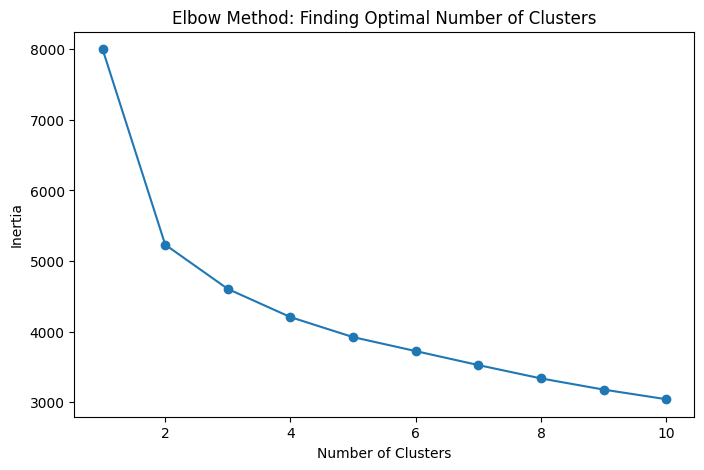

In [183]:
inertia_values = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans_test = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_test.fit(features_scaled)
    inertia_values.append(kmeans_test.inertia_)

# Plot inertia values
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method: Finding Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

*Practice:*  
Inspect the plot and decide on a suitable number of clusters (e.g., 3 or 4). Experiment with different values and see how it affects your results.

In [184]:
# Your Code Here


<details><summary>Click here for solution</summary>

```python
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans.fit(features_scaled)

# Retrieve the cluster labels
cluster_labels = kmeans.labels_
print("Cluster labels for the first 10 rows:", cluster_labels[:10])
```

</details>

## Step 6: K-Means Clustering

Once you decide on the number of clusters, fit the K-Means model to your scaled features and assign cluster labels back to the original dataset.

In [185]:
# Let's assume the optimal number of clusters is 3
kmeans_model = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
kmeans_model.fit(features_scaled)

# Retrieve cluster labels
labels = kmeans_model.labels_

# Add the cluster labels to the original dataframe
data['Cluster'] = labels
data.head()

,Budget (USD),Duration (Months),NumWorkers,SafetyIncidents,Location,ProjectType,MaterialType,ProjectPhase,Cluster
0,8.019766e+05,13.909114,25.0,0,3,2,5,1,0
1,4.462831e+06,41.549995,249.0,11,4,1,5,0,1
2,2.878828e+06,38.596890,240.0,7,6,2,3,0,1
3,4.587195e+06,27.338770,264.0,10,3,2,5,2,1
4,4.633083e+06,49.706087,232.0,10,3,2,5,0,1


## Step 7: Visualizing the Clusters

Visualizing the results can help you interpret how the projects are grouped. Here, we create a scatter plot of **Budget (USD)** vs **Duration (Months)**, coloring each point by its cluster label. We also mark the cluster centroids.

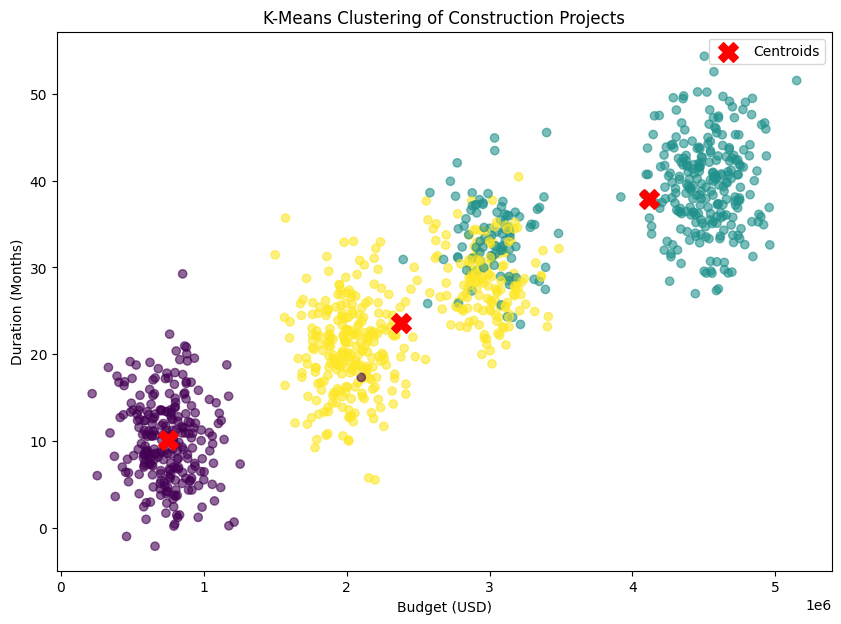

In [186]:
# Extract cluster centroids in scaled space
centroids = kmeans_model.cluster_centers_

# To plot centroids on the original scale, we inverse-transform them
centroids_original = scaler.inverse_transform(centroids)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    data["Budget (USD)"], 
    data["Duration (Months)"], 
    c=data["Cluster"], 
    cmap='viridis', 
    alpha=0.6
)
plt.xlabel("Budget (USD)")
plt.ylabel("Duration (Months)")
plt.title("K-Means Clustering of Construction Projects")

# Plot the centroids
plt.scatter(
    centroids_original[:, features.columns.get_loc("Budget (USD)")],
    centroids_original[:, features.columns.get_loc("Duration (Months)")],
    marker='X', 
    s=200, 
    c='red', 
    label='Centroids'
)
plt.legend()
plt.show()


*Practice:*  
Try other feature pairs like **NumWorkers** vs **SafetyIncidents** or **Budget (USD)** vs **SafetyIncidents** to see how the clusters differ across different dimensions.

In [195]:
# Your Code Here


<details><summary>Click here for solution</summary>

```python
plt.figure(figsize=(10, 7))
plt.scatter(
    data["NumWorkers"], 
    data["SafetyIncidents"], 
    c=data["Cluster"], 
    cmap='plasma', 
    alpha=0.6
)
plt.xlabel("Number of Workers")
plt.ylabel("Safety Incidents Score")
plt.title("Clusters by Workers vs Safety Incidents")
plt.show()
```

</details>

## Why Does the 3‑Cluster Plot Look So “Off”?

When we fit K‑Means using *all* features (Budget, Duration, NumWorkers, SafetyIncidents, etc.), the clustering algorithm is working in a **higher‐dimensional space**. However, when we visualize it in just **two** dimensions (Budget vs. Duration), the clusters may look strange or “overlapping.” That **does not necessarily mean** the clustering is incorrect—K‑Means is grouping points based on *all* features, not just the two we are plotting.

Remember:
- A “perfect” visual separation in 2D will not always happen if the model is using many dimensions.
- The cluster boundaries in higher‐dimensional space might not be obvious when projected down to just two axes.



## Clustering Using Only Budget & Duration

If you *truly* want to cluster projects **only** by their Budget and Duration, you can select just these two columns before fitting K‑Means. Here’s a minimal example showing what that code and plot might look like:


In this 2D-only approach, you will usually see **more “cleanly” separated** clusters—simply because K‑Means is now *only* considering distances along those two dimensions. This often “looks better” in a scatter plot but misses out on any differences in safety incidents, number of workers, or other project attributes that *might* also be important for cluster separation.



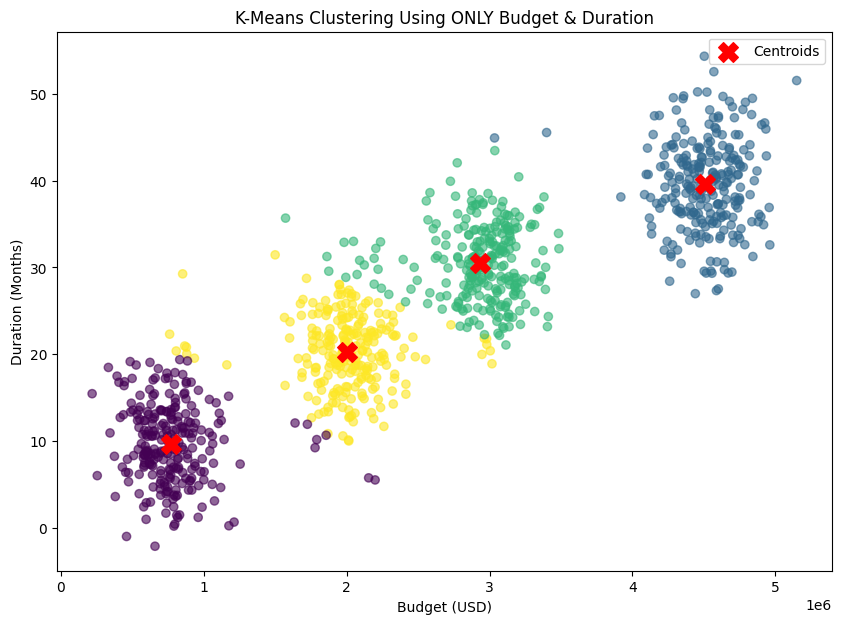

In [191]:
# 1. Select only the two columns we care about
features_2d = data[["Budget (USD)", "Duration (Months)"]]

# 2. Scale them
scaler_2d = StandardScaler()
features_2d_scaled = scaler_2d.fit_transform(features_2d)

# 3. Fit K-Means using ONLY these two features
kmeans_2d = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
kmeans_2d.fit(features_2d_scaled)
labels_2d = kmeans_2d.labels_

# 4. Get centroids (in scaled space) and transform back to original scale
centroids_2d_scaled = kmeans_2d.cluster_centers_
centroids_2d = scaler_2d.inverse_transform(centroids_2d_scaled)

# 5. Plot the clusters and their centroids
plt.figure(figsize=(10,7))
plt.scatter(
    data["Budget (USD)"],
    data["Duration (Months)"],
    c=labels_2d,
    cmap='viridis',
    alpha=0.6
)

# Mark centroids
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title("K-Means Clustering Using ONLY Budget & Duration")
plt.xlabel("Budget (USD)")
plt.ylabel("Duration (Months)")
plt.legend()
plt.show()



### Key Takeaways

1. **Dimensionality Matters**:  
   When using *all* features for K‑Means, you are clustering in a higher‐dimensional space. A 2D plot will not always reflect that higher‐dimensional structure clearly.

2. **“Bad” Looking Plot Isn’t Always Wrong**:  
   The fact that clusters overlap in a 2D projection does not prove the clustering is “wrong”; it only shows that, in 2D, the projects aren’t easily separable.

3. **If You Only Care About Two Variables, Use Only Two Variables**:  
   If your goal is specifically to group projects by Budget and Duration, then select only those columns. You’ll see a neater scatter plot. But remember—this excludes all other information (workers, safety, etc.).

4. **Explain to Stakeholders**:  
   In real‐world scenarios, emphasize that “we used all features to define clusters, so they’re not meant to be obvious in a 2D scatter plot.” The algorithm’s job is to find structure in the *full* feature space, not just one slice.




### Thank you and good luck!
